In [1]:
%matplotlib widget
# 3rd party
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import numpy as np
# from matplotlib.colors import LogNorm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk

# import tensorflow as tf

In [2]:
study_dir = Path(f"/Users/jochoa4/Desktop/studies/preprocessing_debug_05-27-2025/")
study_dir.mkdir(parents=True, exist_ok=True)

plot_dir = study_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

In [3]:
tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.loc[
        tce_tbl["label"].isin(["EB", "KP", "CP", "NTP", "NEB", "NPC"])
]
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_62867/1253199906.py:5: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)


In [4]:
# dataset hyperparameters
n_durations_window = 5  # number of transit durations in each extracted window
it_mask_n_durations_window = 3 # number of tds to mask, for selecting OOT examples w/o overlap
sg_it_mask_n_durations_window = 2 # number of tds to mask, for SG detrending

weak_sec_mask_maxmes_thr = 7.1 # threshold for considering tce's ws signal in transit mask

frac_valid_cadences_in_window_thr = 0.85
frac_valid_cadences_it_thr = 0.85

buffer_time = (
    30  # in minutes, between in-transit cadences and out-of-transit cadences
)

gap_width = 0.75
resampled_num_points = 100  # number of points in the window after resampling

rnd_seed = 42
size_img = [11, 11]  # resize images to this size
f_size = [
    3,
    3,
]  # enlarge `size_img` by these factors; final dimensions are f_size * size_img
center_target = False  # center target in images

## Specific (target, sector_run) Analysis

In [5]:
## TCE of interest
# tce_uid =  "178168644-1-S7"

# target = tce_uid.split('-')[0]
# sector_run = tce_uid.split('S')[-1]

# Target, Sector Run of interest
target, sector_run = "260647166", "1-13" #"309528896", "1-39" # "30034081", "7" # "198242678", "14-19" # "178168644", "7"

rng = np.random.default_rng(seed=rnd_seed)

if plot_dir:
    plot_dir_target_sector_run = (
        plot_dir / f"t_{target}_sr_{sector_run}"
    )
    plot_dir_target_sector_run.mkdir(exist_ok=True, parents=True)
else:
    plot_dir_target_sector_run = None

# # If plotting example info from tfrec
# tfrec_dir = Path("/Users/jochoa4/Desktop/datasets/TESS_exoplanet_dataset_05-04-2025_split_norm/tfrecords/train") # None
# tfrec_fp = tfrec_dir /   "norm_train_shard_2990-8611.tfrecord" #"norm_train_shard_2442-8611.tfrecord" # None

lc_dir = Path("/Users/jochoa4/Downloads/")

In [6]:
def _load_target_sector_run_data(df, target, sector_run):
    return df[(df["target_id"] == int(target)) & (df["sector_run"] == str(sector_run))].copy()

sector_run_data = _load_target_sector_run_data(tce_tbl, target, sector_run)
sector_run_data.head()

,taskFileId,targetIndexNumber,target_id,numberOfPlanets,tce_plnt_num,numberOfAlerts,tce_max_sngle_ev,tce_max_mult_ev,planetCandidate.maxSesInMes,planetCandidate.suspectedEclipsingBinary,...,label_astronet-qlp,matched_villanova_ebs,match_corr_coef_villanova_ebs,tec_fluxtriage_pass,tec_fluxtriage_comment,matched_object,tce_dikco_msky_original,tce_dikco_msky_err_original,tce_dicco_msky_original,tce_dicco_msky_err_original
108224,13889.0,1.0,260647166,4.0,1,2.0,11.029784,15.330164,10.000129,0.0,...,NaN,NaN,NaN,1.0,PASS,1233.01,10.446285,2.554357,10.671672,2.824286
108225,13889.0,1.0,260647166,4.0,2,2.0,11.608452,16.248206,11.553506,0.0,...,NaN,NaN,NaN,1.0,PASS,1233.02,9.311096,9.879234,9.499694,9.821181
108226,13889.0,1.0,260647166,4.0,3,2.0,7.602285,11.350176,7.035923,0.0,...,NaN,NaN,NaN,1.0,PASS,1233.03,4.067780,6.160580,4.185597,6.929475
108227,13889.0,1.0,260647166,4.0,4,2.0,8.018653,8.657715,3.889178,0.0,...,NaN,NaN,NaN,1.0,PASS,1233.04,5.086239,5.330752,4.533605,6.045975


In [7]:
sector_run_data[["disposition", "tce_maxmes"]]

,disposition,tce_maxmes
108224,CP,8.094789
108225,CP,4.761408
108226,CP,2.713222
108227,CP,2.234619


In [8]:
sector_run_arr = []

if "-" in sector_run:
    start_sector, end_sector = [
        int(sector) for sector in sector_run.split("-")
    ]
    sector_run_arr = [
        sector for sector in range(start_sector, end_sector + 1)
    ]
else:
    sector_run_arr = [int(sector_run)]

# find light curve data for target, sector_run pair

search_lc_res = lk.search_lightcurve(
    target=f"tic{target}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_run_arr,
)

lcfs = search_lc_res.download_all(
    download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
)

found_sectors = [int(el.split(' ')[-1]) for el in search_lc_res.table["mission"]]
assert len(found_sectors) != 0

print(f"Found {len(found_sectors)} sectors with light curve data for target, sector_run: {target}, {sector_run}.")


Found 2 sectors with light curve data for target, sector_run: 260647166, 1-13.


In [9]:
target_sector_run_tce_data = []

for (
    tce_i,
    tce_data,
) in sector_run_data.iterrows():  # get all tces in target, sector_run pair
    target_sector_run_tce_data.append(
        {
            "tce_time0bk": tce_data["tce_time0bk"],
            "tce_period": tce_data["tce_period"],
            "tce_duration": tce_data["tce_duration"],
            "tce_maxmes": tce_data["tce_maxmes"],
            "tce_maxmesd": tce_data["tce_maxmesd"],
        }
    )

In [10]:
def build_transit_mask_for_lightcurve(
    time,
    tce_list,
    n_durations_window: int = 5,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)
    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        duration /= 24  # convert hours to days
        
        #distance to nearest transit center (days)
        transit_proximity_days = ((time - epoch + 0.5 * period) % period - 0.5 * period)
        in_transit_mask |= np.abs(transit_proximity_days) <= (
            ((n_durations_window * duration) / 2)
        )
    return in_transit_mask

def build_secondary_transit_mask_for_lightcurve(
    time,
    tce_list,
    n_durations_window: int = 5,
    maxmes_threshold: float = 7.1,
):

    in_transit_mask = np.zeros(len(time), dtype=bool)

    for tce in tce_list:
        epoch = tce["tce_time0bk"]
        period = tce["tce_period"]
        duration = tce["tce_duration"]

        maxmes = tce["tce_maxmes"]
        maxmesd = tce["tce_maxmesd"]

        duration /= 24  # convert hours to days
        if maxmes > maxmes_threshold:
            secondary_epoch = epoch + maxmesd
            transit_proximity_days = ((time - secondary_epoch + 0.5 * period) % period - 0.5 * period)
        
            in_transit_mask |= np.abs(transit_proximity_days) <= (
            ((n_durations_window * duration) / 2)
        )# transit mask buffer corresponds to points that cannot be within a oot flux window of n_durations size

    return in_transit_mask

In [11]:
target_sector_run_tce_data

[{'tce_time0bk': 1571.335518422489,
  'tce_period': 14.175671208274045,
  'tce_duration': 3.774856753279808,
  'tce_maxmes': 8.094788551330566,
  'tce_maxmesd': 1.0555551052093506},
 {'tce_time0bk': 1586.56686361056,
  'tce_period': 19.59340855118269,
  'tce_duration': 4.0975407830206265,
  'tce_maxmes': 4.761408185475729,
  'tce_maxmesd': -2.7749988201617275},
 {'tce_time0bk': 1572.3982832743231,
  'tce_period': 6.20318326507299,
  'tce_duration': 3.1026753484699308,
  'tce_maxmes': 2.7132218876030323,
  'tce_maxmesd': 3.8916650120586382},
 {'tce_time0bk': 1572.111754414116,
  'tce_period': 3.795303571144214,
  'tce_duration': 2.312992835638321,
  'tce_maxmes': 2.234618604011821,
  'tce_maxmesd': 2.208332394422996}]

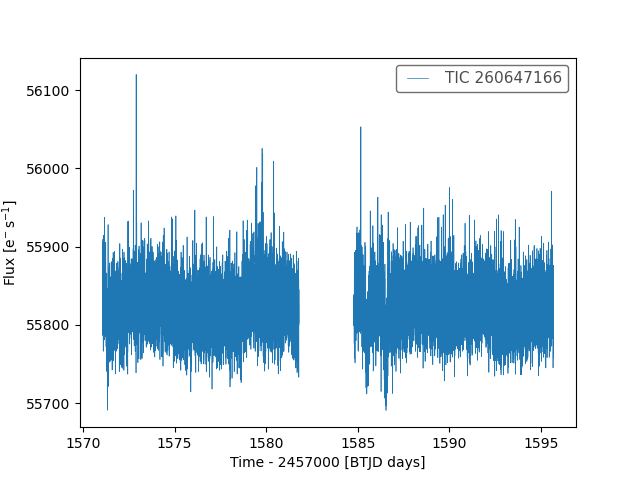

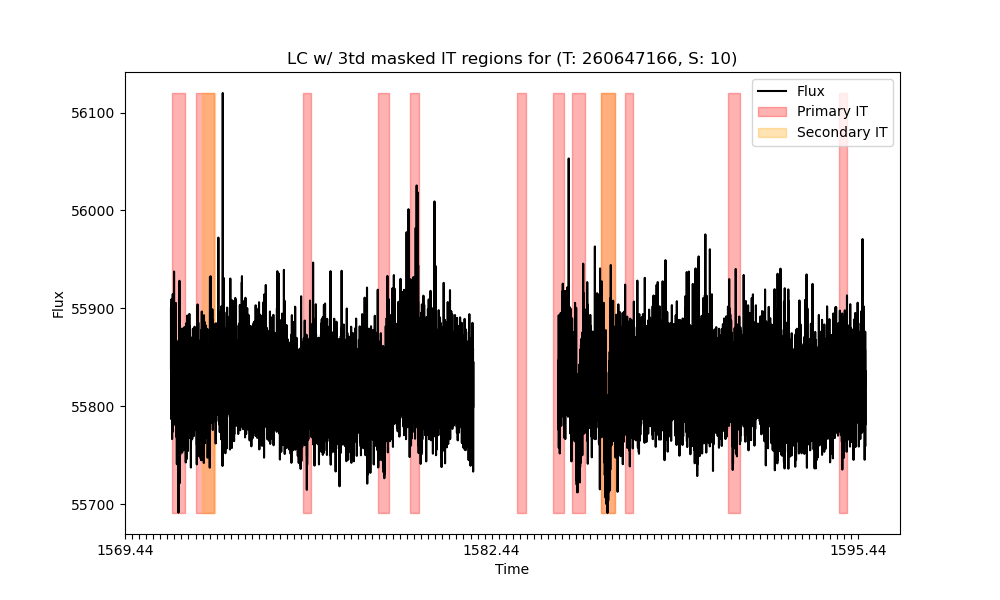

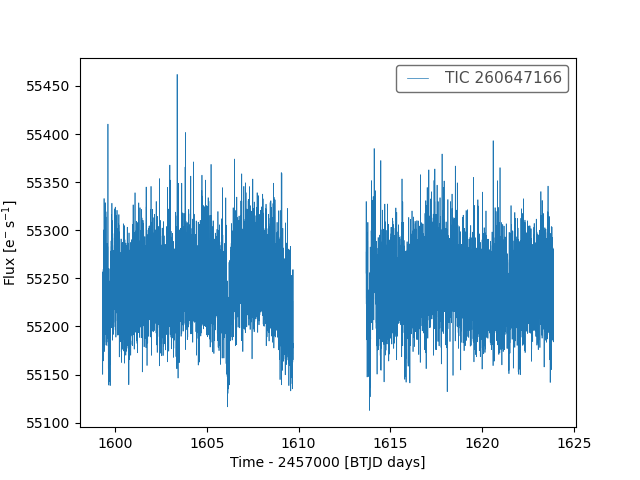

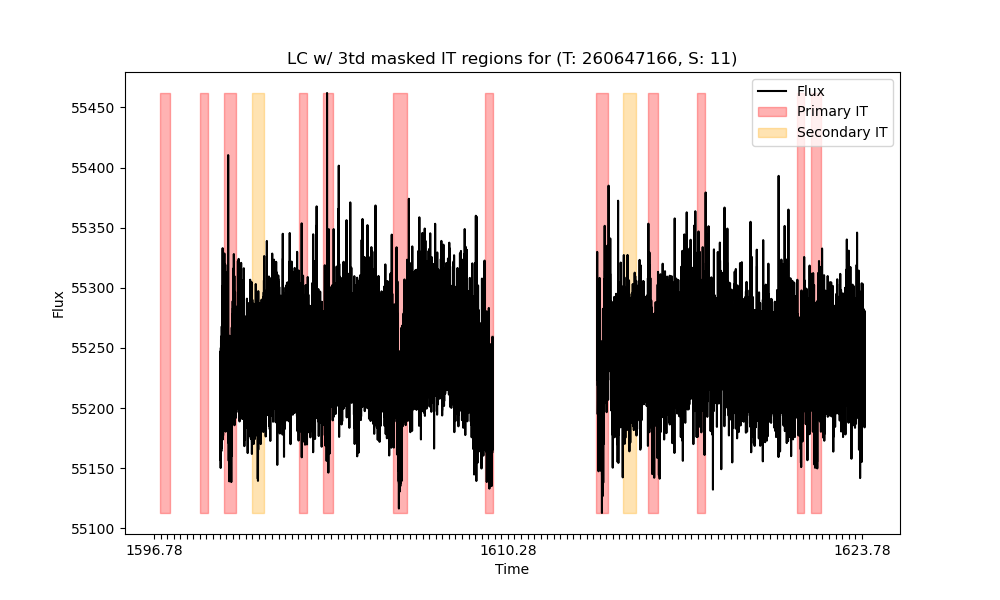

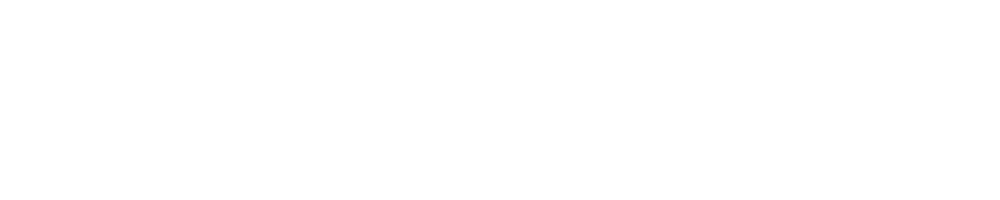

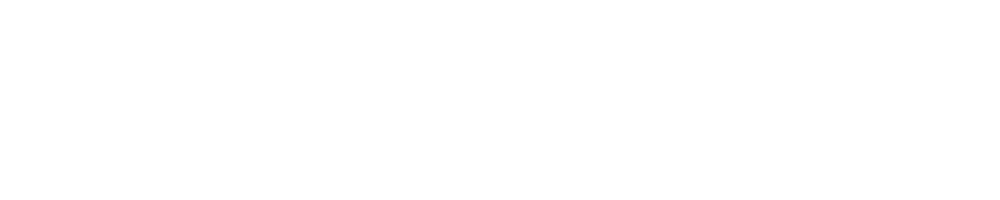

In [ ]:
# for given sector in sector_run
for sector, lcf in zip(found_sectors, lcfs):
    data_for_tce_sector = {
        "sector": sector,
        "transit_examples": {
            "flux": [],
            "t": [],
            "it_img": [],
            "oot_img": [],
            "diff_img": [],
            "snr_img": [],
            "target_img": [],
            "target_pos": [],
        },
        "not_transit_examples": {
            "flux": [],
            "t": [],
            "it_img": [],
            "oot_img": [],
            "diff_img": [],
            "snr_img": [],
            "target_img": [],
            "target_pos": [],
        },
    }
    if plot_dir_target_sector_run:
        plot_dir_target_sector_run_sector = (
            plot_dir_target_sector_run / f"S_{sector}"
        )
        plot_dir_target_sector_run_sector.mkdir(exist_ok=True, parents=True)
    else:
        plot_dir_target_sector_run_sector = None

    # lcf = lk.LightCurve(
    #     {"time": lcf.time.value, "flux": np.array(lcf.flux.value)}
    # )  # np array accounts for masked flux

    # plt.figure(figsize=(10,2))

    # f, ax = plt.subplots()
    # lcf.plot(ax=ax)
    # # ax.set_xlim([t_start, t_end])
    # # ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | True Label {win_label}")
    # # f.savefig(ex_plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")
    # plt.show()

    raw_time, raw_flux = np.array(lcf.time.value), np.array(lcf.flux.value)

    # in_transit_mask = np.zeros(len(raw_time), dtype=bool)
    primary_in_transit_mask = np.zeros(len(raw_time), dtype=bool)
    secondary_in_transit_mask = np.zeros(len(raw_time), dtype=bool)

    # Mask for primary transit
    primary_in_transit_mask = build_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        n_durations_window=it_mask_n_durations_window,
    )

    # Mask for weak secondary transits > maxmes threshold
    secondary_in_transit_mask = build_secondary_transit_mask_for_lightcurve(
        time=raw_time,
        tce_list=target_sector_run_tce_data,
        n_durations_window=it_mask_n_durations_window,
        maxmes_threshold=weak_sec_mask_maxmes_thr,
    )

    plt.figure(figsize=(10,6))
    plt.plot(raw_time, raw_flux, label='Flux', color='black')
    
    #overlay it regions as shaded bands
    plt.fill_between(raw_time, np.nanmin(raw_flux), np.nanmax(raw_flux),
                    where=(primary_in_transit_mask),
                    color='red', alpha=0.3,
                    label="Primary IT")
    plt.fill_between(raw_time, np.nanmin(raw_flux), np.nanmax(raw_flux),
                     where=secondary_in_transit_mask,
                     color='orange', alpha=0.3,
                     label="Secondary IT")
    
    xticks = np.arange(np.nanmin(raw_time), np.nanmax(raw_time), 0.25)
    labels = [f"{t:.2f}" if i in [0, len(xticks) // 2, len(xticks) - 1 ] else '' for i, t in enumerate(xticks)]
    plt.xticks(ticks=xticks,
                labels=labels
            )
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.title(f"LC w/ {it_mask_n_durations_window}td masked IT regions for (T: {target}, S: {sector})")
    plt.legend()
    plt.savefig(plot_dir_target_sector_run_sector / f"{it_mask_n_durations_window}_td_masked_lc_t_{target}_s_{sector}.png")
    plt.show()

# Choosing interesting (target, sector_run) pairs

In [ ]:
# scores_tbls_dir = Path(
#     "/Users/jochoa4/Desktop/pfe_transfers/predict_model_05-04-2025_v2_e19/"
# )

# scores_tbl_fp = scores_tbls_dir / "preds_train.csv"

# train_tbl = pd.read_csv(scores_tbls_dir / "preds_train.csv")

# def _get_tce_uid_from_examples(x):
#     tce_uid = x["uid"].split("_")[0]
#     return tce_uid

# def _get_target_id_from_examples(x):
#     target_id = x["uid"].split("-")[0]
#     return target_id

# train_tbl["tce_uid"] = train_tbl.apply(_get_tce_uid_from_examples, axis=1)
# train_tbl["target_id"] = train_tbl.apply(_get_target_id_from_examples, axis=1)

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_max_mult_ev"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_time0bk"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_period"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )


# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_max_mult_ev"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_maxmes"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_maxmesd"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "tce_time0bk"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

# train_tbl = train_tbl.merge(
#     tce_tbl[["tce_uid", "sector_run"]],
#     on="tce_uid",
#     how="left",
#     validate="many_to_one",
# )

Examples from Target Sectors with TCEs w/ tce_maxmes > 7.1 and tce_maxmes < 7.1

In [13]:
groups = tce_tbl.groupby(["target_id", "sector_run"])

In [14]:
prim_and_sec_exs = groups.filter(lambda g: 
                                 (g["disposition"].isin(["EB", "CP", "KP"]).sum() > 1) 
                                 and 
                                 ((g["tce_maxmes"] > 7.1).any()) and ((g["tce_maxmes"] < 7.1).any())
                                )

In [15]:
prim_and_sec_groups = prim_and_sec_exs.groupby(["target_id", "sector_run"])

In [16]:
prim_and_sec_groups.size().sort_values()

target_id  sector_run
11437325   18            2
237277760  22            2
           50            2
           53            2
404103665  14-19         2
                        ..
269701147  14-23         3
316207527  12            3
260647166  1-13          4
142276270  14-23         4
309528896  1-39          4
Length: 66, dtype: int64

In [25]:
prim_and_sec_df = prim_and_sec_groups.get_group((309528896, "1-39"))
prim_and_sec_df.head()[["tce_uid", "disposition", "tce_maxmes", "tce_period_err", "tce_duration_err", "tce_model_snr"]]

,tce_uid,disposition,tce_maxmes,tce_period_err,tce_duration_err,tce_model_snr
186144,309528896-1-S1-39,EB,973.087219,-1.000000,-1.000000,-1.000000
186145,309528896-2-S1-39,NTP,145.170709,-1.000000,-1.000000,-1.000000
186146,309528896-3-S1-39,EB,73.661743,0.000003,0.061136,88.273691
186147,309528896-4-S1-39,NTP,5.035738,-1.000000,-1.000000,-1.000000


In [ ]:
# sec_exs = groups.filter(lambda g: (g["disposition"].isin(["EB", "CP", "KP"]).sum() > 1) and ((g["tce_maxmes"] > 7.1).any()))[["target_id", "sector_run", "tce_maxmes"]]

In [ ]:
# sec_groups = sec_exs.groupby(["target_id", "sector_run"])

In [ ]:
# sec_groups.size().sort_values()

In [ ]:
# prim_and_sec_exs = groups.filter(lambda g: (g["disposition"].isin(["EB", "CP", "KP"]).sum() > 1) and ((g["tce_maxmes"] > 7.1).any()) and ((g["tce_maxmes"] < 7.1).any()))

In [ ]:
prim_and_sec_exs.sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "tce_period_err"]]

In [18]:
p_prim_and_sec_exs = groups.filter(lambda g: (g["disposition"].isin(["CP", "KP"]).sum() > 1) and ((g["tce_maxmes"] > 7.1).any()) and ((g["tce_maxmes"] < 7.1).any()))

In [19]:
p_prim_and_sec_exs.sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "tce_period_err"]]

,target_id,sector_run,tce_period_err
116784,259377017,5,0.002730
108225,260647166,1-13,0.002461
116779,259377017,3,0.001761
100882,142276270,21,0.001669
100883,142276270,21,0.001425
29597,269701147,14-19,0.001227
108224,260647166,1-13,0.000956
74006,374180079,1-46,0.000915
116780,259377017,3,0.000804
100897,142276270,14-23,0.000780


In [20]:
prim_and_sec_exs.sort_values("tce_duration_err", axis=0, ascending=False)[["target_id", "sector_run", "tce_duration_err"]]

,target_id,sector_run,tce_duration_err
32350,30034081,7,2508.213111
105434,167304040,1-65,12.379755
76766,224308601,51,1.578093
12248,346599599,24,1.081086
58811,160228595,60,1.068184
...,...,...,...
58809,160228595,60,-1.000000
58672,155894704,21,-1.000000
58671,155894704,21,-1.000000
46389,391902612,1-65,-1.000000


In [21]:
prim_and_sec_exs.sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "tce_time0bk_err"]]

,target_id,sector_run,tce_time0bk_err
32350,30034081,7,54.238865
116784,259377017,5,0.002007
750,160618494,25,0.009032
108225,260647166,1-13,0.001802
10281,284457791,50,0.015472
...,...,...,...
58809,160228595,60,-1.000000
58672,155894704,21,-1.000000
58671,155894704,21,-1.000000
46389,391902612,1-65,-1.000000


In [26]:
high_err_prim_and_sec_df = prim_and_sec_groups.get_group((30034081, "7"))
high_err_prim_and_sec_df.head()[["tce_uid", "disposition", "tce_maxmes", "tce_period_err", "tce_duration_err", "tce_model_snr"]]

,tce_uid,disposition,tce_maxmes,tce_period_err,tce_duration_err,tce_model_snr
32348,30034081-1-S7,EB,14.115034,-1.000000,-1.000000,-1.000000
32349,30034081-2-S7,NTP,44.240826,-1.000000,-1.000000,-1.000000
32350,30034081-3-S7,EB,4.993200,4.914087,2508.213111,0.003054


In [27]:
high_err_p_prim_and_sec_df = prim_and_sec_groups.get_group((260647166, "1-13"))
high_err_p_prim_and_sec_df.head()[["tce_uid", "disposition", "tce_maxmes", "tce_period_err", "tce_duration_err", "tce_model_snr"]]

,tce_uid,disposition,tce_maxmes,tce_period_err,tce_duration_err,tce_model_snr
108224,260647166-1-S1-13,CP,8.094789,0.000956,0.269953,17.274744
108225,260647166-2-S1-13,CP,4.761408,0.002461,0.182519,17.105404
108226,260647166-3-S1-13,CP,2.713222,0.000652,0.208869,13.137519
108227,260647166-4-S1-13,CP,2.234619,0.000381,0.435173,9.561176


In [ ]:
t_tce_tbl = tce_tbl[tce_tbl["disposition"].isin(["EB", "CP", "KP"])]

In [ ]:
t_tce_tbl.sort_values("tce_time0bk_err", axis=0, ascending=False)[["target_id", "sector_run", "disposition", "tce_time0bk_err", ]]

In [ ]:
t_tce_tbl.sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "disposition", "tce_period_err"]]

In [ ]:
t_tce_tbl["is_msr"] = t_tce_tbl.apply(lambda r: ('-' in r["sector_run"]), axis=1)


In [ ]:
t_tce_tbl[t_tce_tbl["is_msr"] == True].sort_values("tce_period_err", axis=0, ascending=False)[["target_id", "sector_run", "disposition", "tce_period_err"]]

In [ ]:
fits_fp = 
lcf = lk.read(fits_fp)